# Random Forest Classification of X-ray Images

This notebook uses scikit-learn random forest to classify X-ray images into good coverage and poor coverage. 

## Import packages, define metrics, prepare datasets

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.ndimage import gaussian_filter
from astropy.stats import sigma_clipped_stats
from scipy.stats import wilcoxon
import random
random.seed(46)

def binarize(image):
    out = np.copy(image)
    out[out>0]=1
    return out

In [2]:
def countZeroPixels(image):
    """Return the number of value-zero pixels in the image."""
    image=image.flatten()
    return len(image)-np.count_nonzero(image)

def getImageContrast(image):
    """Calculate a simple measure of the image contrast."""
    image=image.flatten()
    image = image[image>0]
    maxp = np.max(image)
    minp = np.min(image)
    return (maxp-minp)/(maxp+minp)

def npixelsAboveNoise(image,threshold=5):
    """Calculate the number pixels above X*sigma of the noise."""
    image=image.flatten()
    image=image[image>0]
    rmsnoise = np.sqrt(np.mean(image**2.))
    return len(image[np.where(image>threshold*rmsnoise)])

def meanSepBrightPixels(image,threshold=5):
    """Return the mean separation (in px) between bright pixels."""
    image=image.flatten()
    image=image[image>0]
    #rmsnoise = np.sqrt(np.mean(image**2.))
    sel = np.where(image>0)#threshold*rmsnoise)
    if len(sel[0])==0:
        return 300
    else:
        return (90000/len(image[sel]))**0.5

def medianBrightYPosition(image,threshold=10):
    """Compute the median y-value among bright pixels."""
    rmsnoise = np.sqrt(np.mean(image**2.))
    positions = np.where(image>threshold*rmsnoise)
    return np.median(positions[0])

def medianBrightXPosition(image, threshold=10):
    """Compute the median x-value among bright pixels."""
    rmsnoise = np.sqrt(np.mean(image**2.))
    positions = np.where(image>threshold*rmsnoise)
    return np.median(positions[1])

def lr_contrast(image):
    # left and right sections of image
    left = image[:, :150]
    right = image[:, 150:]
    return np.abs(getImageContrast(left)-getImageContrast(right))

def ud_contrast(image):
    # left and right sections of image
    up = image[150:, :]
    down = image[:150, :]
    return np.abs(getImageContrast(up)-getImageContrast(down))

def triangular_contrast1(image):
    # get upper, lower triangle
    upper = np.triu(image)
    lower = np.tril(image)
    return np.abs(getImageContrast(upper)-getImageContrast(lower))

def triangular_contrast2(image):
    # get upper, lower triangle
    upper = np.triu(np.fliplr(image))
    lower = np.tril(np.fliplr(image))
    return np.abs(getImageContrast(upper)-getImageContrast(lower))

def ud_difference(image, threshold=10):
    image = binarize(image)
    # left and right sections of image
    #rmsnoise = np.sqrt(np.mean(image**2.))
    up = image[150:, :]
    down = image[:150, :]
    #return (np.sum(up.flatten())-np.sum(down.flatten()))
    #n_bright_up = len(up[up>threshold*rmsnoise])
    #n_bright_down = len(down[down>threshold*rmsnoise])
    return np.sum(up)-np.sum(down)#np.abs(n_bright_up-n_bright_down)

def lr_difference(image, threshold=10):
    image = binarize(image)
    # left and right sections of image
    #rmsnoise = np.sqrt(np.mean(image**2.))
    left = image[:, :150]
    right = image[:, 150:]
    #return (np.sum(left.flatten())-np.sum(right.flatten()))
    #n_bright_l = len(left[left>threshold*rmsnoise])
    #n_bright_r = len(right[right>threshold*rmsnoise])
    return np.sum(left)-np.sum(right) #np.abs(n_bright_l-n_bright_r)

def tri_difference1(image,threshold=10):
    # get upper, lower triangle
    image = binarize(image)
    #rmsnoise = np.sqrt(np.mean(image**2.))
    upper = np.triu(image)
    lower = np.tril(image)
    #n_upper = len(upper[upper>threshold*rmsnoise])
    #n_lower = len(lower[lower>threshold*rmsnoise])
    return np.sum(upper)-np.sum(lower)#np.abs(n_upper-n_lower)

def tri_difference2(image,threshold=10):
    # get upper, lower triangle
    image=binarize(image)
    #rmsnoise = np.sqrt(np.mean(image**2.))
    upper = np.triu(np.fliplr(image))
    lower = np.tril(np.fliplr(image))
    #n_upper = len(upper[upper>threshold*rmsnoise])
    #n_lower = len(lower[lower>threshold*rmsnoise])
    return np.sum(upper)-np.sum(lower)#np.abs(n_upper-n_lower)

def lr_zero(image, threshold=10):
    # left and right sections of image
    left = image[:, :150]
    right = image[:, 150:]
    n_bright_l = len(left[left==0])
    n_bright_r = len(right[right==0])
    return np.abs(n_bright_l-n_bright_r)

def ud_zero(image, threshold=10):
    # left and right sections of image
    up = image[150:, :]
    down = image[:150, :]
    n_bright_up = len(up[up==0])
    n_bright_down = len(down[down==0])
    return np.abs(n_bright_up-n_bright_down)

def symmetry_lr(image, clipsigma=10):
    orig = binarize(np.copy(image))
    #clippedmean, jk, jk = sigma_clipped_stats(image[image!=0], sigma=10, maxiters=2, cenfunc=np.mean)
    #image[image>clipsigma*clippedmean] = clippedmean
    flipped = np.fliplr(image)
    diff = np.sum([image, -1*flipped], axis=0)
    return np.sqrt(np.mean(diff**2.))

def symmetry_ud(image, clipsigma=10):
    orig = binarize(np.copy(image))
    #clippedmean, jk, jk = sigma_clipped_stats(image[image!=0], sigma=10, maxiters=2, cenfunc=np.mean)
    #image[image>clipsigma*clippedmean] = clippedmean
    flipped = np.flipud(image)
    diff = np.sum([image, -1*flipped], axis=0)
    return np.sqrt(np.mean(diff**2.))

def symmetry_diag(image, clipsigma=10):
    orig = binarize(np.copy(image))
    #clippedmean, jk, jk = sigma_clipped_stats(image[image!=0], sigma=10, maxiters=2, cenfunc=np.mean)
    #image[image>clipsigma*clippedmean] = clippedmean
    flipped = image.T
    diff = np.sum([image, -1*flipped], axis=0)
    return np.sqrt(np.mean(diff**2.))

def moransI(x):
    x=binarize(x)
    w = np.zeros_like(x)+1
    xbar = np.median(x[x>0])
    top = np.sum(w*(x-xbar)*(x.T-xbar))
    bottom = np.sum((x-xbar)**2.)
    N = x.shape[0]*x.shape[1]
    return (N/np.sum(w))*top/bottom

def meansnr(image):
    return np.mean(image)/np.std(image)

def quadrant_sums(k):
    k = binarize(k)
    sums=[np.sum(k[0:150,0:150]), np.sum(k[0:150,150:300]), np.sum(k[150:300,0:150]), np.sum(k[150:300,150:300])]
    return (max(sums)-min(sums))/max(sums)

#metadata_funcs = [countZeroPixels, meansnr, quadrant_sums]
metadata_funcs = [symmetry_lr, symmetry_ud, symmetry_diag, countZeroPixels, meansnr, quadrant_sums] #~93%
#metadata_funcs = [ud_difference, lr_difference, tri_difference1, tri_difference2, countZeroPixels, meansnr, quadrant_sums, meanSepBrightPixels]
                 #tri_difference1, tri_difference2, meanSepBrightPixels],\
                 # npixelsAboveNoise, getImageContrast,]
#metadata_funcs = [ud_difference, lr_difference, lr_zero, ud_zero, meanSepBrightPixels,\
#                  npixelsAboveNoise, getImageContrast, countZeroPixels, tri_difference1, tri_difference2]

In [3]:
x = np.array([[2,2], [36,1]])

In [4]:
moransI(x)

/afs/cas.unc.edu/users/z/h/zhutchen/.conda/envs/astro3/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars


nan

## Metadata proof of concept

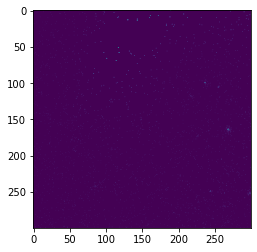

([0.23304744390598045,
  0.23390406390465113,
  0.23395156193822117,
  87466,
  0.17020945156740427,
  0.47342995169082125],
 491.0779657331244)

In [5]:
testimage = fits.open('/srv/scratch/zhutchen/khess_images/poor_coverage/RASS-Int_Hard_grp9530.0_.fits')[0].data

plt.figure()
plt.imshow(testimage)
plt.show()

[fx(binarize(testimage)) for fx in metadata_funcs], np.max(testimage)/np.mean(testimage)

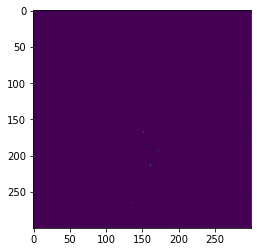

([0.24189070075368982,
  0.2449943310001728,
  0.2425329301810833,
  87239,
  0.17790078480160373,
  0.6521739130434783],
 1897.5628399578295)

In [6]:
testimage = fits.open('/srv/scratch/zhutchen/khess_images/poor_coverage/RASS-Int_Hard_grp3562.0_.fits')[0].data

plt.figure()
plt.imshow(testimage)
plt.show()

[fx(binarize(testimage)) for fx in metadata_funcs], np.max(testimage)/np.mean(testimage)

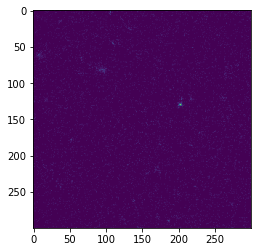

([0.3828547737429661,
  0.3828547737429661,
  0.38186675977652496,
  82814,
  0.29457217772472555,
  0.17787971457696228],
 142.6105578313369)

In [7]:
testimage = fits.open('/srv/scratch/zhutchen/khess_images/nondetections/RASS-Int_Hard_grp10007.0_.fits')[0].data

plt.figure()
plt.imshow(testimage)
plt.show()

[fx(binarize(testimage)) for fx in metadata_funcs], np.max(testimage)/np.mean(testimage)

# Create training/validation dataset

In [8]:
imagesXgood = []
labelsygood = []
imagesXpoor = []
labelsypoor = []

goodcount=[]
dpath = "/srv/scratch/zhutchen/khess_images/detections/"
for f in os.listdir(dpath):
    if f.endswith('.fits'):
        #imagesX.append(np.array(fits.open(dpath+f)[0].data).flatten())
        image = (fits.open(dpath+f)[0].data)
        goodcount.append(countZeroPixels(image))
        imagesXgood.append(np.array([fx(image) for fx in metadata_funcs]))
        labelsygood.append('good_coverage')

ndpath = "/srv/scratch/zhutchen/khess_images/nondetections/"
for f in os.listdir(ndpath):
    if f.endswith('.fits'):
        #imagesX.append(np.array(fits.open(ndpath+f)[0].data).flatten())
        image = (fits.open(ndpath+f)[0].data)
        goodcount.append(countZeroPixels(image))
        imagesXgood.append(np.array([fx(image) for fx in metadata_funcs]))
        labelsygood.append('good_coverage')

i=0
testarray=[]
pcpath = "/srv/scratch/zhutchen/khess_images/poor_coverage/"
for f in os.listdir(pcpath):
    if f.endswith('.fits') and i>-1:
        #imagesX.append(np.array(fits.open(pcpath+f)[0].data).flatten()) #flatten each 300x300 image to 1x90000
        image = (fits.open(pcpath+f)[0].data)
        testarray.append(countZeroPixels(image))
        imagesXpoor.append(np.array([fx(image) for fx in metadata_funcs]))
        labelsypoor.append('poor_coverage')
        i+=1

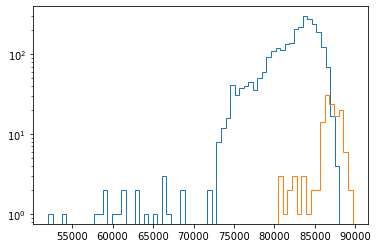

In [9]:
plt.figure()
plt.hist(goodcount, bins='fd', label='good images', histtype='step')
plt.hist(testarray, bins='fd', label='poor images', histtype='step')
plt.yscale('log')
plt.show()

In [10]:
len(imagesXgood), len(imagesXpoor)

(2746, 132)

Since we aren't going to augment our poor coverage images, we need to randomly sample 132 good images from the entire list (to match our poor images).

In [11]:
imagesXgood = random.sample(imagesXgood, 128)
assert (np.array(labelsygood)=='good_coverage').all()
labelsygood = labelsygood[0:128] # all 'good_coverage', so it doesn't matter if we sample or not
assert len(imagesXgood)==len(labelsygood)

Now we should combine the good/poor arrays.

In [12]:
imagesX = imagesXgood+imagesXpoor
labelsy = labelsygood+labelsypoor

In [13]:
# test: double their sizes to see how accuracy responds
#imagesX.extend(imagesX)
#labelsy.extend(labelsy)
#print(len(imagesX), len(labelsy))

Finally, we should split the data into two sets for training and validation.

In [14]:
trsplit = 0.8
imagesXtrain, imagesXtest, labelsytrain, labelsytest = train_test_split(imagesX, labelsy,\
                                                                        test_size=1-trsplit, random_state=46)

In [15]:
len(imagesXtrain), len(imagesXtest)

(208, 52)

Now just shuffle the data to remove the pattern of file transformations.

In [16]:
imagesXtrain, labelsytrain = shuffle(imagesXtrain, labelsytrain, random_state=46)
imagesXtest, labelsytest = shuffle(imagesXtest, labelsytest, random_state=46)



## Initiate Classifier 

In [17]:
clf = RandomForestClassifier()

## Training the Model

In [18]:
# breakdown valiation sample
labelsytrain = np.array(labelsytrain)
labelsytest = np.array(labelsytest)
print("Percent of poor coverage in training sample: {}".format(len(labelsytrain[labelsytrain=='poor_coverage'])/len(labelsytrain)))
print("Percent of poor coverage in validation sample: {}".format(len(labelsytest[labelsytest=='poor_coverage'])/len(labelsytest)))

Percent of poor coverage in training sample: 0.5240384615384616
Percent of poor coverage in validation sample: 0.4423076923076923


In [19]:
clf.fit(imagesXtrain, labelsytrain)

RandomForestClassifier()

## Test the results 

In [20]:
preds = clf.predict(imagesXtest)
print("Accuracy: ", accuracy_score(labelsytest,preds))

Accuracy:  0.9038461538461539


/afs/cas.unc.edu/users/z/h/zhutchen/.conda/envs/astro3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  


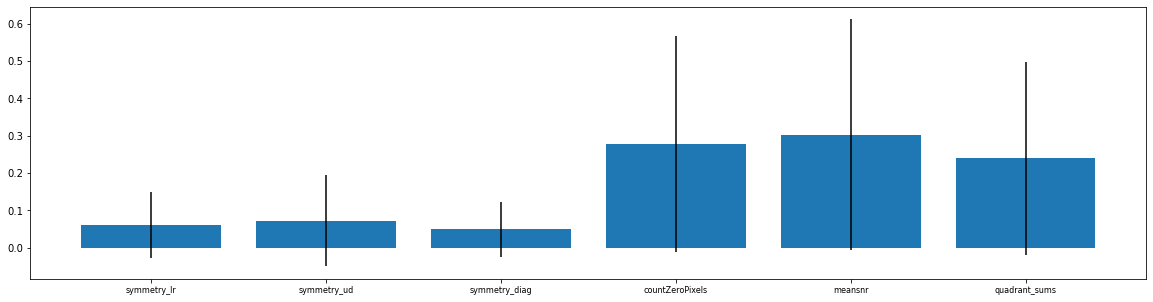

1.0000000000000002


In [21]:
importances = clf.feature_importances_
feature_names = [f.__name__ for f in metadata_funcs]
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
plt.figure(figsize=(20,5))
plt.bar(feature_names, importances, yerr=std)
plt.gca().set_xticklabels(feature_names, fontsize=8)
plt.show()
print(np.sum(importances))

## Test individual images

[[8.85713492e-04 8.85309199e-04 8.86918150e-04 8.37030000e+04
  2.55986322e-01 1.95232690e-01]]


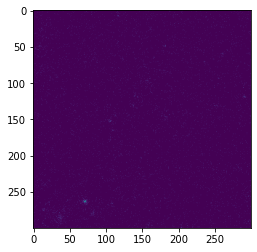

[[1. 0.]]
['good_coverage']


In [22]:
image = fits.open("/srv/two/zhutchen/rosat_xray_stacker/g3rassimages/eco/RASS-Int_Hard_grp10042.0_ECO00491.fits")
image = image[0].data
image_metadata = np.array([fx(image) for fx in metadata_funcs]).reshape(1,-1)
print(image_metadata)

plt.figure()
plt.imshow(image)
plt.show()

print(clf.predict_proba(image_metadata))
print(clf.predict(image_metadata))

[[1.62607590e-03 1.62513237e-03 1.62502308e-03 8.41320000e+04
  2.25711291e-01 5.30260708e-01]]


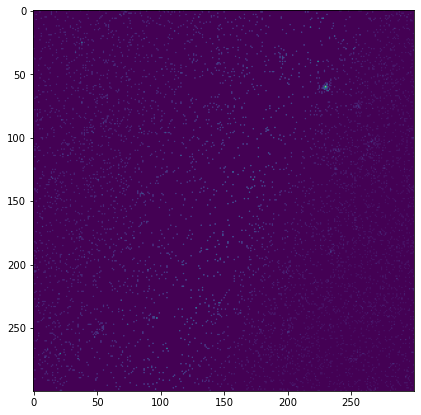

NameError: name 'image_metadaquadrant_sums' is not defined

In [23]:
image = fits.open("/srv/scratch/zhutchen/khess_images/poor_coverage/RASS-Int_Hard_grp11771.0_.fits")
image = image[0].data
image_metadata = np.array([fx(image) for fx in metadata_funcs]).reshape(1,-1)
print(image_metadata)

plt.figure(figsize=(7,7))
plt.imshow(image)
plt.show()

print(clf.predict_proba(image_metadaquadrant_sums, ta))
print(clf.predict(image_metadata))

In [ ]:
rmsnoise = np.sqrt(np.mean(image**2.))
print(rmsnoise)

In [ ]:
image = fits.open("/srv/scratch/zhutchen/khess_images/poor_coverage/RASS-Int_Hard_grp3543.0_.fits")
image = image[0].data
image_metadata = np.array([fx(image) for fx in metadata_funcs]).reshape(1,-1)
print(image_metadata)

plt.figure(figsize=(7,7))
plt.imshow(image)
plt.show()

print(clf.predict_proba(image_metadata))
print(clf.predict(image_metadata))

In [ ]:
image = fits.open("/srv/two/zhutchen/rosat_xray_stacker/g3rassimages/eco/RASS-Int_Hard_grp10003.0_ECO00441.fits")
image = image[0].data
image_metadata = np.array([fx(image) for fx in metadata_funcs]).reshape(1,-1)

plt.figure(figsize=(7,7))
plt.imshow(image)
plt.show()

print(clf.predict_proba(image_metadata))
print(clf.predict(image_metadata))

## Test on all the original poor coverage images

In [ ]:
origtestimages=[]
origtestlabels=[]

origpcpath = "/srv/scratch/zhutchen/khess_images/poor_coverage/"
for f in os.listdir(origpcpath):
    if f.endswith('.fits'):
        #imagesX.append(np.array(fits.open(pcpath+f)[0].data).flatten()) #flatten each 300x300 image to 1x90000
        image = fits.open(pcpath+f)[0].data
        origtestimages.append(np.array([fx(image) for fx in metadata_funcs]))
        origtestlabels.append('poor_coverage')
        i+=1

norig = len(origtestimages)
print(norig)
        
origtestimages.extend(imagesXgood[int(trsplit*len(imagesXgood)):][0:norig])
origtestlabels.extend(labelsygood[int(trsplit*len(labelsygood)):][0:norig])

In [ ]:
len(origtestimages)

In [ ]:
preds = clf.predict(origtestimages)
print("Accuracy: ", accuracy_score(origtestlabels,preds))
